# Training Data Evaluation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting, reduction
import pandas
from enum import Enum
import scipy.spatial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.tree import export_graphviz
import pydot
import pickle
from joblib import dump, load
import os.path


%load_ext autoreload
%autoreload 2
%matplotlib inline

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

In [17]:
class SubmapState(Enum):
    ALL_GOOD = 1
    LOCAL_GOOD = 2
    NO_GOOD = 3

class WaveletEvaluator(object):

    def __init__(self, n_scales = 7):
        self.n_scales = n_scales

    def set_scales(self, n_scales):
        self.n_scales = n_scales

    def compare_signals(self, G, x_1, x_2):

        # Compute the wavelets for each node and scale.
        psi = self.compute_wavelets(G)
        print(f"[WaveletEvaluator] psi = {psi.shape}")

        # Compute the wavelet coefficients for x_1 and x_2.
        W_1 = self.compute_wavelet_coefficients(psi, x_1)
        W_2 = self.compute_wavelet_coefficients(psi, x_2)
        print(f"[WaveletEvaluator] W_1 = {W_1.shape}")
        print(f"[WaveletEvaluator] W_2 = {W_2.shape}")


    def compute_wavelets(self, G):
        print(f"[WaveletEvaluator] Computing wavelets for {self.n_scales}")
        g = filters.Meyer(G, self.n_scales)

        # Evalute filter bank on the frequencies (eigenvalues).
        f = g.evaluate(G.e)
        f = np.expand_dims(f.T, 1)
        psi = np.zeros((G.N, G.N, self.n_scales))

        for i in range(0, G.N):

            # Create a Dirac centered at node i.
            x = np.zeros((G.N,1))
            x[i] = 1

            # Transform the signal to spectral domain.
            s = G._check_signal(x)
            s = G.gft(s)

            # Multiply the transformed signal with filter.
            if s.ndim == 1:
                s = np.expand_dims(s, -1)
            s = np.expand_dims(s, 1)
            s = np.matmul(s, f)

            # Transform back the features to the vertex domain.
            psi[i, :, :] = G.igft(s).squeeze()

        return psi

    def compute_wavelets_coeffs(self, wavelet, x_signal):
        n_values = x_signal.shape[0]
        W = np.zeros((n_values, self.n_scales))
        for i in range(0, n_values):
            for j in range(0, self.n_scales):
                W[i,j] = np.matmul(wavelet[i,:,j].transpose(), x_signal)

        return W

    def check_submap(self, coeffs_1, coeffs_2, submap_ids):
        submap_coeffs_1 = coeffs_1[submap_ids, :]
        submap_coeffs_2 = coeffs_2[submap_ids, :]

        D = self.compute_generic_distance(submap_coeffs_1, submap_coeffs_2)
        #D = self.compute_cosine_distance(submap_coeffs_1, submap_coeffs_2)
        #print(f"dist: {D.transpose()}")
        return self.evaluate_scales(D)
    
    def compute_features_for_submap(self, coeffs_1, coeffs_2, submap_ids):
        submap_coeffs_1 = coeffs_1[submap_ids, :]
        submap_coeffs_2 = coeffs_2[submap_ids, :]
        
        D = self.compute_distances(submap_coeffs_1, submap_coeffs_2)
                              
        data = np.array([
            # Cosine distance.
            np.sum(D[0, 0:2]),
            np.sum(D[0, 2:4]),
            np.sum(D[0, 5:]),
            
            # Euclidean distance.
            np.sum(D[1, 0:2]),
            np.sum(D[1, 2:4]),
            np.sum(D[1, 5:]),
            
            # Bray-Curtis distance.
            np.sum(D[2, 0:2]),
            np.sum(D[2, 2:4]),
            np.sum(D[2, 5:]),
            
            # Correlation.
            np.sum(D[3, 0:2]),
            np.sum(D[3, 2:4]),
            np.sum(D[3, 5:]),
            
            # Canberra distance.
            np.sum(D[4, 0:2]),
            np.sum(D[4, 2:4]),
            np.sum(D[4, 5:]),
            
            # JSD.
            np.sum(D[5, 0:2]),
            np.sum(D[5, 2:4]),
            np.sum(D[5, 5:]),
            
            # Minkowski distance.
            np.sum(D[6, 0:2]),
            np.sum(D[6, 2:4]),
            np.sum(D[6, 5:]),
            
            # Cityblock distance.
            np.sum(D[7, 0:2]),
            np.sum(D[7, 2:4]),
            np.sum(D[7, 5:]),
            
            # Chebyshev distance.
            np.sum(D[8, 0:2]),
            np.sum(D[8, 2:4]),
            np.sum(D[8, 5:]),            
        ])
        
        return data
        

    def compute_cosine_distance(self, coeffs_1, coeffs_2):
        #print(f"c1 {coeffs_1.shape} and c2 {coeffs_2.shape}")
        cosine_distance = np.zeros((self.n_scales, 1))
        for j in range(0, self.n_scales):
            cross = np.dot(coeffs_1[:,j], coeffs_2[:,j])
            n_1 = np.linalg.norm(coeffs_1[:,j])
            n_2 = np.linalg.norm(coeffs_2[:,j])


            cosine_similarity = cross/(n_1*n_2)
            cosine_distance[j] = 1 - cosine_similarity
        return cosine_distance
    
    def compute_distances(self, coeffs_1, coeffs_2):
        distances = np.zeros((9, self.n_scales))            
        for j in range(0, self.n_scales):      
            #w = np.abs(np.divide(coeffs_1[:,j], coeffs_2[:,j]))
            distances[0, j] = scipy.spatial.distance.cosine(coeffs_1[:,j], coeffs_2[:,j])
            distances[1, j] = scipy.spatial.distance.euclidean(coeffs_1[:,j], coeffs_2[:,j])
            distances[2, j] = scipy.spatial.distance.braycurtis(coeffs_1[:,j], coeffs_2[:,j])
            distances[3, j] = scipy.spatial.distance.correlation(coeffs_1[:,j], coeffs_2[:,j])
            distances[4, j] = scipy.spatial.distance.canberra(coeffs_1[:,j], coeffs_2[:,j])
            distances[5, j] = scipy.spatial.distance.jensenshannon(coeffs_1[:,j], coeffs_2[:,j])
            distances[6, j] = scipy.spatial.distance.minkowski(coeffs_1[:,j], coeffs_2[:,j])         
            distances[7, j] = scipy.spatial.distance.cityblock(coeffs_1[:,j], coeffs_2[:,j])         
            distances[8, j] = scipy.spatial.distance.chebyshev(coeffs_1[:,j], coeffs_2[:,j])
            
        return distances

    def evaluate_scales(self, D):
        k_eps = 0.3
        
        sum_lower = np.sum(D[0:2])
        print(f"Lower sum resulting in {sum_lower.transpose()}")
        
        sum_band = np.sum(D[2:4])
        print(f"Band sum resulting in {sum_band.transpose()}")
        
        sum_higher = np.sum(D[5:])
        print(f"Higher sum resulting in {sum_higher.transpose()}")
        sum_total = sum_lower + sum_higher
        print(f"--------------------")

        if (sum_total < k_eps):
            return SubmapState.ALL_GOOD
        elif (sum_lower < k_eps and sum_higher >= k_eps):
            return SubmapState.LOW_GOOD
        elif (sum_lower >= k_eps and sum_higher < k_eps):
            return SubmapState.HIGH_GOOD
        else:
            return SubmapState.NO_GOOD


## Load Input from File

In [23]:
dataroot = '/mnt/data/datasets/fgsp/'
datasets = ['gonzen_mission_01_cerberus/', 'gonzen_mission_03_cerberus/']

n_datasets = len(datasets)
opt_signals = []
est_signals = []
opt_trajectory = []
est_trajectory = []
for ds in datasets:
    ds_path = dataroot + ds
    print(f'Loading data from {ds_path}')
    opt_signal_path = ds_path + 'opt_signal.npy'
    opt_traj_path = ds_path + 'opt_trajectory.npy'
    est_signal_path = ds_path + 'est_signal.npy'
    est_traj_path = ds_path + 'est_trajectory.npy'  
 
    if os.path.isfile(opt_signal_path) and os.path.isfile(est_signal_path):
        opt_signals.append(np.load(opt_signal_path))
        est_signals.append(np.load(est_signal_path))
        
    if os.path.isfile(opt_traj_path) and os.path.isfile(est_traj_path):
        opt_trajectory.append(np.load(opt_traj_path))
        est_trajectory.append(np.load(est_traj_path))
    
print(f'=======================================')
n_datasets = len(opt_signals)
n_trajectories = len(opt_trajectory)
assert n_datasets == len(est_signals)
assert n_trajectories == len(opt_trajectory)
print(f'Finished loading {n_datasets} datasets and {n_trajectories} trajectories.')

Loading data from /mnt/data/datasets/fgsp/gonzen_mission_01_cerberus/
Loading data from /mnt/data/datasets/fgsp/gonzen_mission_03_cerberus/
Finished loading 2 datasets and 1 trajectories.


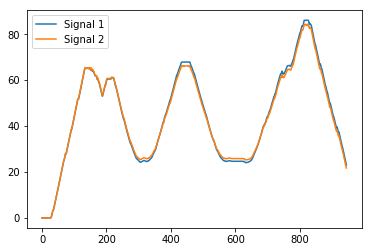

Signal shapes are (946,) and (946,)


In [13]:
def compare_signals(signal_1, signal_2):
    plt.plot(signal_1, label='Signal 1')
    plt.plot(signal_2, label='Signal 2')
    plt.legend()
    plt.show()

i = 0
compare_signals(est_signals[i], opt_signals[i])
print(f'Signal shapes are {est_signals[i].shape} and {opt_signals[i].shape}')

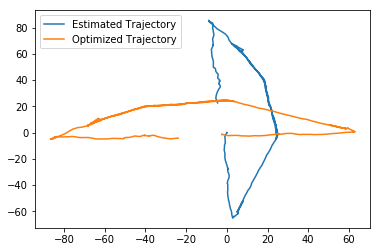

Signal shapes are (946, 3) and (946, 3)


In [26]:
def compare_trajectories(est_traj, opt_traj):    
    plt.plot(est_traj[:,0], est_traj[:,1], label='Estimated Trajectory')
    plt.plot(opt_traj[:,0], opt_traj[:,1], label='Optimized Trajectory')
    plt.legend()
    plt.show()
    
i = 0
compare_trajectories(est_trajectory[i], opt_trajectory[i])
print(f'Signal shapes are {est_trajectory[i].shape} and {opt_trajectory[i].shape}')

----------------------------------------
## Learn a Random Forest Classifier

In [16]:
all_data = pandas.DataFrame([])
feature_names = ['Distance',
                 'Cosine_L', 
                 'Cosine_B', 
                 'Cosine_H',
                 'Euclidean_L',
                 'Euclidean_B',
                 'Euclidean_H',
                 'BrayCurtis_L',
                 'BrayCurtis_B',
                 'BrayCurtis_H',
                 'Correlation_L',
                 'Correlation_B',
                 'Correlation_H',
                 'Canberra_L',
                 'Canberra_B',
                 'Canberra_H',
                 'JSD_L',
                 'JSD_B',
                 'JSD_H',
                 'Minkowski_L',
                 'Minkowski_B',
                 'Minkowski_H',
                 'Manhattan_L',
                 'Manhattan_B',
                 'Manhattan_H',
                 'Chebyshev_L',
                 'Chebyshev_B',
                 'Chebyshev_H']


## Position-based Difference

In [14]:
for i in range(0, n_datasets):
    n_est_signal = len(est_signals[i])
    n_opt_signal = len(opt_signals[i])
    assert n_est_signal == n_opt_signal

### Additive noise

In [19]:
noise_levels = np.arange(0.005, 0.25, 0.001)
for sigma in noise_levels:    
    samples_1 = np.random.normal(0, sigma, G.N)
    samples_2 = np.random.normal(0, sigma, G.N)
    samples_3 = np.random.normal(0, sigma, G.N)
    shifted_opt_graph = opt_graph + np.array([samples_1, samples_2, samples_3]).transpose()

    opt_origin = opt_graph[0,:]
    opt_pos_signal = (opt_graph - opt_origin).squeeze()

    shifted_opt_origin = shifted_opt_graph[0,:]
    shifted_opt_pos_signal = (shifted_opt_origin - shifted_opt_graph).squeeze()

    x_1 = np.linalg.norm(opt_pos_signal, ord=2, axis=1)
    x_2 = np.linalg.norm(shifted_opt_pos_signal, ord=2, axis=1)

    W_1 = eval.compute_wavelets_coeffs(psi, x_1)
    W_2 = eval.compute_wavelets_coeffs(psi, x_2)

    n_submaps = 40
    submap_size = int(G.N/n_submaps)

    indices = []
    submap_indices = []
    state_signal = np.zeros((G.N, 1))

    submap_data = []
    for i in range(0, G.N):
        n_indices_in_submap = len(submap_indices)

        # If the submap reached max size, evaluate it.

        if n_indices_in_submap > 0 and n_indices_in_submap % submap_size == 0:        
            features = eval.compute_features_for_submap(W_1, W_2, submap_indices)
            submap_data.append(features)

            submap_indices = []

        submap_indices.append(i)
        
    # TODO(lbern): add remaining submaps
        
    submap_data = np.array(submap_data)        
    label = 0
    data=pandas.DataFrame({
        feature_names[0]:submap_data[:,0],
        feature_names[1]:submap_data[:,1],
        feature_names[2]:submap_data[:,2],

        feature_names[3]:submap_data[:,3],
        feature_names[4]:submap_data[:,4],
        feature_names[5]:submap_data[:,5],

        feature_names[6]:submap_data[:,6],
        feature_names[7]:submap_data[:,7],
        feature_names[8]:submap_data[:,8],

        feature_names[9]:submap_data[:,9],
        feature_names[10]:submap_data[:,10],
        feature_names[11]:submap_data[:,11],

        feature_names[12]:submap_data[:,12],
        feature_names[13]:submap_data[:,13],
        feature_names[14]:submap_data[:,14],

        feature_names[15]:submap_data[:,15],
        feature_names[16]:submap_data[:,16],
        feature_names[17]:submap_data[:,17],

        feature_names[18]:submap_data[:,18],
        feature_names[19]:submap_data[:,19],
        feature_names[20]:submap_data[:,20],

        feature_names[21]:submap_data[:,21],
        feature_names[22]:submap_data[:,22],
        feature_names[23]:submap_data[:,23],

        feature_names[24]:submap_data[:,24],
        feature_names[25]:submap_data[:,25],
        feature_names[26]:submap_data[:,26],
        'state':label
    })

    all_data=all_data.append(data)

### Drift 

In [20]:
noise_levels = np.arange(0.0001, 0.0011, 0.0001)
for sigma in noise_levels:    
    noise = np.array([0.0, 0.0, 0.0])
    shifted_opt_graph = np.copy(opt_graph)
    for i in range(0, G.N):
        noise[0] += np.abs(np.random.normal(0, sigma, 1))
        noise[1] += np.abs(np.random.normal(0, sigma, 1))
        noise[2] += np.abs(np.random.normal(0, sigma, 1))
        shifted_opt_graph[i] += noise.transpose()

    opt_origin = opt_graph[0,:]
    opt_pos_signal = (opt_graph - opt_origin).squeeze()

    shifted_opt_origin = shifted_opt_graph[0,:]
    shifted_opt_pos_signal = (shifted_opt_origin - shifted_opt_graph).squeeze()

    x_1 = np.linalg.norm(opt_pos_signal, ord=2, axis=1)
    x_2 = np.linalg.norm(shifted_opt_pos_signal, ord=2, axis=1)

    W_1 = eval.compute_wavelets_coeffs(psi, x_1)
    W_2 = eval.compute_wavelets_coeffs(psi, x_2)
    
    n_submaps = 40
    submap_size = int(G.N/n_submaps)

    indices = []
    submap_indices = []
    state_signal = np.zeros((G.N, 1))

    submap_data = []
    for i in range(0, G.N):
        n_indices_in_submap = len(submap_indices)

        # If the submap reached max size, evaluate it.

        if n_indices_in_submap > 0 and n_indices_in_submap % submap_size == 0:        
            features = eval.compute_features_for_submap(W_1, W_2, submap_indices)
            submap_data.append(features)

            submap_indices = []

        submap_indices.append(i)
        
    # TODO(lbern): add remaining submaps
        
    submap_data = np.array(submap_data)        
    label = 0
    data=pandas.DataFrame({
        feature_names[0]:submap_data[:,0],
        feature_names[1]:submap_data[:,1],
        feature_names[2]:submap_data[:,2],

        feature_names[3]:submap_data[:,3],
        feature_names[4]:submap_data[:,4],
        feature_names[5]:submap_data[:,5],

        feature_names[6]:submap_data[:,6],
        feature_names[7]:submap_data[:,7],
        feature_names[8]:submap_data[:,8],

        feature_names[9]:submap_data[:,9],
        feature_names[10]:submap_data[:,10],
        feature_names[11]:submap_data[:,11],

        feature_names[12]:submap_data[:,12],
        feature_names[13]:submap_data[:,13],
        feature_names[14]:submap_data[:,14],

        feature_names[15]:submap_data[:,15],
        feature_names[16]:submap_data[:,16],
        feature_names[17]:submap_data[:,17],

        feature_names[18]:submap_data[:,18],
        feature_names[19]:submap_data[:,19],
        feature_names[20]:submap_data[:,20],

        feature_names[21]:submap_data[:,21],
        feature_names[22]:submap_data[:,22],
        feature_names[23]:submap_data[:,23],

        feature_names[24]:submap_data[:,24],
        feature_names[25]:submap_data[:,25],
        feature_names[26]:submap_data[:,26],
        'state':label
    })

    all_data=all_data.append(data)

### Bad Drift

In [21]:
noise_levels = np.arange(0.01, 0.055, 0.001)
for sigma in noise_levels:    
    noise = np.array([0.0, 0.0, 0.0])
    shifted_opt_graph = np.copy(opt_graph)
    for i in range(0, G.N):
        noise[0] += np.abs(np.random.normal(0, sigma, 1))
        noise[1] += np.abs(np.random.normal(0, sigma, 1))
        noise[2] += np.abs(np.random.normal(0, sigma, 1))
        shifted_opt_graph[i] += noise.transpose()

    opt_origin = opt_graph[0,:]
    opt_pos_signal = (opt_graph - opt_origin).squeeze()

    shifted_opt_origin = shifted_opt_graph[0,:]
    shifted_opt_pos_signal = (shifted_opt_origin - shifted_opt_graph).squeeze()

    x_1 = np.linalg.norm(opt_pos_signal, ord=2, axis=1)
    x_2 = np.linalg.norm(shifted_opt_pos_signal, ord=2, axis=1)

    W_1 = eval.compute_wavelets_coeffs(psi, x_1)
    W_2 = eval.compute_wavelets_coeffs(psi, x_2)
    
    n_submaps = 40
    submap_size = int(G.N/n_submaps)

    indices = []
    submap_indices = []
    state_signal = np.zeros((G.N, 1))

    submap_data = []
    for i in range(0, G.N):
        n_indices_in_submap = len(submap_indices)

        # If the submap reached max size, evaluate it.

        if n_indices_in_submap > 0 and n_indices_in_submap % submap_size == 0:        
            features = eval.compute_features_for_submap(W_1, W_2, submap_indices)
            submap_data.append(features)

            submap_indices = []

        submap_indices.append(i)
        
    # TODO(lbern): add remaining submaps
        
    submap_data = np.array(submap_data)        
    label = 1
    data=pandas.DataFrame({
        feature_names[0]:submap_data[:,0],
        feature_names[1]:submap_data[:,1],
        feature_names[2]:submap_data[:,2],

        feature_names[3]:submap_data[:,3],
        feature_names[4]:submap_data[:,4],
        feature_names[5]:submap_data[:,5],

        feature_names[6]:submap_data[:,6],
        feature_names[7]:submap_data[:,7],
        feature_names[8]:submap_data[:,8],

        feature_names[9]:submap_data[:,9],
        feature_names[10]:submap_data[:,10],
        feature_names[11]:submap_data[:,11],

        feature_names[12]:submap_data[:,12],
        feature_names[13]:submap_data[:,13],
        feature_names[14]:submap_data[:,14],

        feature_names[15]:submap_data[:,15],
        feature_names[16]:submap_data[:,16],
        feature_names[17]:submap_data[:,17],

        feature_names[18]:submap_data[:,18],
        feature_names[19]:submap_data[:,19],
        feature_names[20]:submap_data[:,20],

        feature_names[21]:submap_data[:,21],
        feature_names[22]:submap_data[:,22],
        feature_names[23]:submap_data[:,23],

        feature_names[24]:submap_data[:,24],
        feature_names[25]:submap_data[:,25],
        feature_names[26]:submap_data[:,26],
        'state':label
    })

    all_data=all_data.append(data)

In [22]:
print(f"Size of all_data = {all_data.shape[0]}")
all_data.tail()

Size of all_data = 12000


,Cosine_L,Cosine_B,Cosine_H,Euclidean_L,Euclidean_B,Euclidean_H,BrayCurtis_L,BrayCurtis_B,BrayCurtis_H,Correlation_L,...,Minkowski_L,Minkowski_B,Minkowski_H,Manhattan_L,Manhattan_B,Manhattan_H,Chebyshev_L,Chebyshev_B,Chebyshev_H,state
35,1.566758e-01,0.147981,2.437961,274.587649,78.642152,38.781744,1.793847,1.690751,2.008013,0.007413,...,274.587649,78.642152,38.781744,1410.384658,339.259179,120.774533,56.623470,24.879953,19.008040,1
36,1.138536e-02,0.425329,1.618783,256.358729,3.289214,99.848057,1.339867,0.876865,1.982886,2.046488,...,256.358729,3.289214,99.848057,1331.724206,15.567021,501.633399,49.581756,0.983510,26.636322,1
37,2.472151e-06,1.999906,0.271851,256.310349,3.089874,132.167607,1.200896,7.457707,1.983236,2.000232,...,256.310349,3.089874,132.167607,1331.827570,16.054694,685.296010,49.332616,0.598669,26.128257,1
38,9.329996e-08,1.999997,0.958219,256.310306,3.098529,126.040213,1.200591,7.593338,1.991605,2.001195,...,256.310306,3.098529,126.040213,1331.827414,16.100402,652.496536,49.327878,0.601264,24.759712,1
39,3.823039e-08,1.999999,1.952902,256.310306,3.097777,133.904082,1.200617,7.582253,1.998542,2.030112,...,256.310306,3.097777,133.904082,1331.827418,16.096508,693.709904,49.327407,0.598297,26.663342,1


In [23]:
all_data = all_data.fillna(0)
all_data = all_data.replace(float('inf'), 1)

# without JSD
#feature_names = ['Cosine_L', 'Cosine_B', 'Cosine_H','Euclidean_L', 'Euclidean_B', 'Euclidean_H','BrayCurtis_L', 'BrayCurtis_B', 'BrayCurtis_H','Correlation_L', 'Correlation_B', 'Correlation_H', 'Canberra_L', 'Canberra_B', 'Canberra_H', 'Minkowski_L', 'Minkowski_B', 'Minkowski_H', 'Manhattan_L', 'Manhattan_B', 'Manhattan_H', 'Chebyshev_L', 'Chebyshev_B', 'Chebyshev_H']

# Full
feature_names = ['Cosine_L', 'Cosine_B', 'Cosine_H','Euclidean_L', 'Euclidean_B', 'Euclidean_H','BrayCurtis_L', 'BrayCurtis_B', 'BrayCurtis_H','Correlation_L', 'Correlation_B', 'Correlation_H', 'Canberra_L', 'Canberra_B', 'Canberra_H', 'JSD_L', 'JSD_B', 'JSD_H', 'Minkowski_L', 'Minkowski_B', 'Minkowski_H', 'Manhattan_L', 'Manhattan_B', 'Manhattan_H', 'Chebyshev_L', 'Chebyshev_B', 'Chebyshev_H']


In [24]:
X=all_data[feature_names]
y=all_data['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

dump(clf, '../config/forest.joblib') 
#clf = load('filename.joblib') 

['../config/forest.joblib']

In [25]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 1.0


No handles with labels found to put in legend.


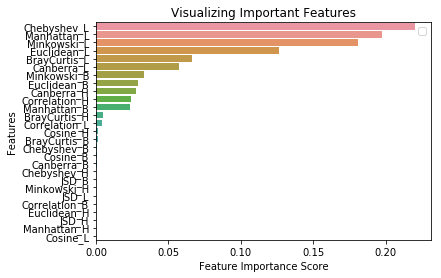

In [26]:
feature_imp = pandas.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()


In [240]:
# Pull out one tree from the forest
tree = clf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

## Real Tests

In [7]:
clf = load('../config/forest.joblib') 

In [ ]:
feature_names = ['Cosine_L', 'Cosine_B', 'Cosine_H','Euclidean_L', 'Euclidean_B', 'Euclidean_H','BrayCurtis_L', 'BrayCurtis_B', 'BrayCurtis_H','Correlation_L', 'Correlation_B', 'Correlation_H', 'Canberra_L', 'Canberra_B', 'Canberra_H', 'JSD_L', 'JSD_B', 'JSD_H', 'Minkowski_L', 'Minkowski_B', 'Minkowski_H', 'Manhattan_L', 'Manhattan_B', 'Manhattan_H', 'Chebyshev_L', 'Chebyshev_B', 'Chebyshev_H']

W_1 = eval.compute_wavelets_coeffs(psi, x_opt)
W_2 = eval.compute_wavelets_coeffs(psi, x_loam)
#W_2 = eval.compute_wavelets_coeffs(psi, x_rovio)

n_submaps = 40
submap_size = int(G.N/n_submaps)

n_all_good = 0
n_low_good = 0
n_high_good = 0
n_no_good = 0

indices = []
submap_indices = []
state_signal = np.zeros((G.N, 1))

submap_data = []
for i in range(0, G.N):
    n_indices_in_submap = len(submap_indices)

    # If the submap reached max size, evaluate it.

    if n_indices_in_submap > 0 and n_indices_in_submap % submap_size == 0:        
        features = eval.compute_features_for_submap(W_1, W_2, submap_indices)
        submap_data.append(features)

        submap_indices = []

    submap_indices.append(i)

submap_data = np.array(submap_data)                
data=pandas.DataFrame({
    feature_names[0]:submap_data[:,0],
    feature_names[1]:submap_data[:,1],
    feature_names[2]:submap_data[:,2],

    feature_names[3]:submap_data[:,3],
    feature_names[4]:submap_data[:,4],
    feature_names[5]:submap_data[:,5],

    feature_names[6]:submap_data[:,6],
    feature_names[7]:submap_data[:,7],
    feature_names[8]:submap_data[:,8],

    feature_names[9]:submap_data[:,9],
    feature_names[10]:submap_data[:,10],
    feature_names[11]:submap_data[:,11],

    feature_names[12]:submap_data[:,12],
    feature_names[13]:submap_data[:,13],
    feature_names[14]:submap_data[:,14],

    feature_names[15]:submap_data[:,15],
    feature_names[16]:submap_data[:,16],
    feature_names[17]:submap_data[:,17],

    feature_names[18]:submap_data[:,18],
    feature_names[19]:submap_data[:,19],
    feature_names[20]:submap_data[:,20],

    feature_names[21]:submap_data[:,21],
    feature_names[22]:submap_data[:,22],
    feature_names[23]:submap_data[:,23],

    feature_names[24]:submap_data[:,24],
    feature_names[25]:submap_data[:,25],
    feature_names[26]:submap_data[:,26]    
})

In [15]:
data = data.fillna(0)
data = data.replace(float('inf'), 1)

prediction = clf.predict(data)
prediction_prob = clf.predict_proba(data)

print(f"Prediction shape {prediction.shape} and prob shape {prediction_prob.shape}")
len(prediction)

Prediction shape (40,) and prob shape (40, 2)


40

In [2]:
a = [1,2,3,4,5,6]
mask = [False,False,True,True,False,False,]
idx = [3,4,0]
#[a[i] for i in range(0,len(a)) if mask[i]]
[a[id] for id in idx]

[4, 5, 1]

In [29]:
np.array([0])[0]

0

150